<a href="https://colab.research.google.com/github/beolawork-art/NovaBank-Churn-Analysis/blob/main/NovaBank_Churn_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

In [ ]:
df = pd.read_csv('novabank_churn_dataset.csv')

In [ ]:
print(df.head())

   customer_id  age  gender  income  account_balance  transactions_per_month  \
0            1   56    Male  619936           203380                      39   
1            2   69    Male  175991           249289                       7   
2            3   46    Male  452732           246127                       4   
3            4   32  Female  556079           237513                      59   
4            5   60    Male  951437            18347                       8   

   app_logins  complaints  card_usage  churn  
0          83           0           2      0  
1          98           0          11      0  
2          65           2          39      0  
3          29           0           1      0  
4          52           0          35      1  


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   customer_id             1000 non-null   int64 
 1   age                     1000 non-null   int64 
 2   gender                  1000 non-null   object
 3   income                  1000 non-null   int64 
 4   account_balance         1000 non-null   int64 
 5   transactions_per_month  1000 non-null   int64 
 6   app_logins              1000 non-null   int64 
 7   complaints              1000 non-null   int64 
 8   card_usage              1000 non-null   int64 
 9   churn                   1000 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 78.3+ KB
None


In [ ]:
df.duplicated()

,0
0,False
1,False
2,False
3,False
4,False
...,...
995,False
996,False
997,False
998,False


In [ ]:
df['gender'] = df['gender'].map({'Female': 0, 'Male': 1})
print(df.head())

   customer_id  age  gender  income  account_balance  transactions_per_month  \
0            1   56       1  619936           203380                      39   
1            2   69       1  175991           249289                       7   
2            3   46       1  452732           246127                       4   
3            4   32       0  556079           237513                      59   
4            5   60       1  951437            18347                       8   

   app_logins  complaints  card_usage  churn  
0          83           0           2      0  
1          98           0          11      0  
2          65           2          39      0  
3          29           0           1      0  
4          52           0          35      1  


In [ ]:
# Create new, categorized columns by grouping the numbers into bins (buckets)

# 🧑‍🦳 Age Groups
# We'll create 4 age groups: Young, Middle, Senior, and Older Adult.
df['Age_Group'] = pd.cut(df['age'],
                         bins=[18, 30, 45, 60, 100],
                         labels=['Young Adult', 'Middle Aged', 'Senior Adult', 'Older Adult'],
                         right=False) # The first number in the bin is included

# 💰 Income Groups (Example using quartiles to make 4 equal groups)
# Quartiles means dividing the data into four parts (Q1, Q2, Q3, Q4)
df['Income_Group'] = pd.qcut(df['income'],
                             q=4, # q=4 means make 4 groups
                             labels=['Q1_Low_Income', 'Q2_Med_Income', 'Q3_High_Income', 'Q4_Top_Income'])

# 🏦 Account Balance Groups
# We'll create 3 simple groups: Low, Medium, and High Balance.
df['Balance_Group'] = pd.cut(df['account_balance'],
                             bins=[-1, 50000, 150000, df['account_balance'].max()],
                             labels=['Low_Balance', 'Medium_Balance', 'High_Balance'])

In [ ]:
# We are creating a new column called 'Txn_Activity_Group'

# Define the boundaries:
# 0-4 transactions = Very Low
# 5-15 transactions = Low
# 16-30 transactions = Medium
# 31+ transactions = High
bins = [-1, 4, 15, 30, df['transactions_per_month'].max() + 1]

df['Txn_Activity_Group'] = pd.cut(
    df['transactions_per_month'],
    bins=bins,
    labels=['Very Low (0-4)', 'Low (5-15)', 'Medium (16-30)', 'High (31+)'],
    right=False # Makes the bin include the lower number (e.g., 5, but not 16)
)

print(df['Txn_Activity_Group'].value_counts())

Txn_Activity_Group
High (31+)        495
Medium (16-30)    264
Low (5-15)        177
Very Low (0-4)     64
Name: count, dtype: int64


In [ ]:
# We are creating a new column called 'Card_Usage_Quartile'

df['Card_Usage_Quartile'] = pd.qcut(
    df['card_usage'],
    q=4, # q=4 means we want 4 equal groups (quartiles)
    labels=['Q1_Lowest_Usage', 'Q2_Low_Usage', 'Q3_High_Usage', 'Q4_Highest_Usage']
)

print(df['Card_Usage_Quartile'].value_counts())

Card_Usage_Quartile
Q3_High_Usage       269
Q1_Lowest_Usage     259
Q2_Low_Usage        246
Q4_Highest_Usage    226
Name: count, dtype: int64


In [ ]:
print(df.head())

   customer_id  age  gender  income  account_balance  transactions_per_month  \
0            1   56       1  619936           203380                      39   
1            2   69       1  175991           249289                       7   
2            3   46       1  452732           246127                       4   
3            4   32       0  556079           237513                      59   
4            5   60       1  951437            18347                       8   

   app_logins  complaints  card_usage  churn     Age_Group    Income_Group  \
0          83           0           2      0  Senior Adult  Q3_High_Income   
1          98           0          11      0   Older Adult   Q1_Low_Income   
2          65           2          39      0  Senior Adult   Q2_Med_Income   
3          29           0           1      0   Middle Aged  Q3_High_Income   
4          52           0          35      1   Older Adult   Q4_Top_Income   

  Balance_Group Txn_Activity_Group Card_Usage_Quar

In [ ]:
# Count how many customers Exited (1) and how many stayed (0)
churn_counts = df['churn'].value_counts()

# Calculate the overall Churn Rate (the percentage who Exited)
churn_rate = churn_counts[1] / len(df) * 100

print("--- Overall Churn Rate ---")
print(f"Total customers: {len(df)}")
print(f"Customers who left (Exited=1): {churn_counts[1]}")
print(f"Overall Churn Rate: {churn_rate:.2f}%")
# The .2f means showing only two numbers after the decimal point

--- Overall Churn Rate ---
Total customers: 1000
Customers who left (Exited=1): 58
Overall Churn Rate: 5.80%


In [ ]:
features_to_check_better = [
    'Age_Group', # New binned feature
    'Income_Group', # New binned feature
    'Balance_Group', # New binned feature
    # Keep the original categorical features that looked fine
    'gender',
   'Txn_Activity_Group',
    'Card_Usage_Quartile'
]

print("--- 📉 Churn Rate (%) by Key Customer Segments (Binned) ---\n")

for feature in features_to_check_better:
    # This calculation now works perfectly with the new groups!
    churn_rates = (df.groupby(feature)['churn'].mean() * 100).round(2)

    print(f"**{feature.replace('_', ' ').title()}**")
    print(churn_rates)
    print("-" * 20)

--- 📉 Churn Rate (%) by Key Customer Segments (Binned) ---

**Age Group**
Age_Group
Young Adult     5.86
Middle Aged     5.61
Senior Adult    6.02
Older Adult     5.67
Name: churn, dtype: float64
--------------------
**Income Group**
Income_Group
Q1_Low_Income     6.8
Q2_Med_Income     5.2
Q3_High_Income    5.6
Q4_Top_Income     5.6
Name: churn, dtype: float64
--------------------
**Balance Group**
Balance_Group
Low_Balance       16.97
Medium_Balance     2.36
High_Balance       4.44
Name: churn, dtype: float64
--------------------
**Gender**
gender
0    5.04
1    6.49
Name: churn, dtype: float64
--------------------
**Txn Activity Group**
Txn_Activity_Group
Very Low (0-4)    42.19
Low (5-15)         7.34
Medium (16-30)     2.27
High (31+)         2.42
Name: churn, dtype: float64
--------------------
**Card Usage Quartile**
Card_Usage_Quartile
Q1_Lowest_Usage     6.95
Q2_Low_Usage        5.28
Q3_High_Usage       7.43
Q4_Highest_Usage    3.10
Name: churn, dtype: float64
-----------------

/tmp/ipython-input-4010816851.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_rates = (df.groupby(feature)['churn'].mean() * 100).round(2)


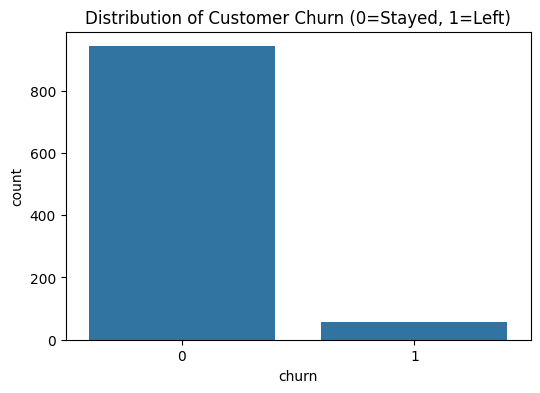

In [ ]:
## Visualize the Churn Count
plt.figure(figsize=(6, 4))
sns.countplot(x='churn', data=df)
plt.title('Distribution of Customer Churn (0=Stayed, 1=Left)')
plt.show()

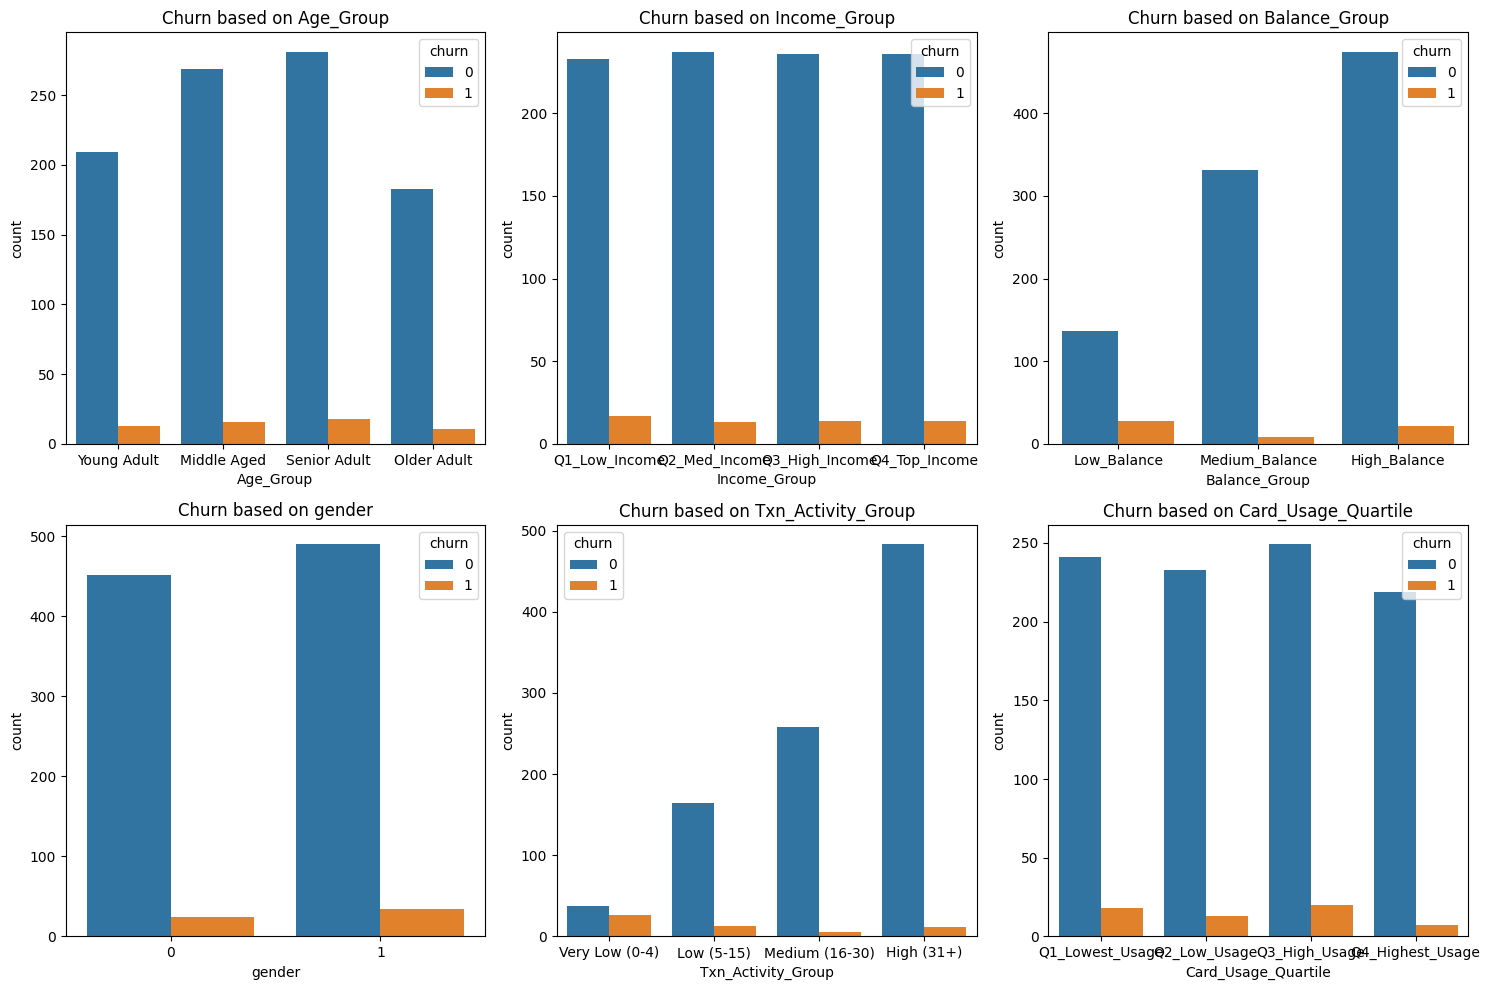

In [ ]:
# Some important categorical columns to check
categorical_eda_cols = ['Age_Group', 'Income_Group', 'Balance_Group', 'gender', 'Txn_Activity_Group', 'Card_Usage_Quartile']

plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_eda_cols):
    plt.subplot(2, 3, i + 1) # Sets up a 2x3 grid for the charts
    sns.countplot(x=col, hue='churn', data=df)
    plt.title(f'Churn based on {col}')
    plt.tight_layout() # Makes sure the charts don't overlap

plt.show()

In [ ]:
# X = Features (All columns EXCEPT the 'Churn' answer column and 'customerID')
# 'axis=1' means drop the column name, not the row.
X = df.drop('churn', axis=1)

# y = Target (Just the Churn answer column)
y = df['churn']

# 2. SPLIT the data into Training (80%) and Testing (20%) sets
# test_size=0.2 means 20% of the data goes to testing.
# random_state=42 is like a secret code to make sure the split is the same every time you run the code.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Optional: Print the size of the piles to check
print(f"Training Features Size: {X_train.shape}")
print(f"Testing Features Size: {X_test.shape}")

Training Features Size: (800, 14)
Testing Features Size: (200, 14)


--- Logistic Regression Model Results ---
Baseline Accuracy (Simple Guess): [Assume Your Majority Class %]
Model Accuracy (Smart Guess): 95.00%

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       189
           1       1.00      0.09      0.17        11

    accuracy                           0.95       200
   macro avg       0.97      0.55      0.57       200
weighted avg       0.95      0.95      0.93       200


--- Confusion Matrix ---


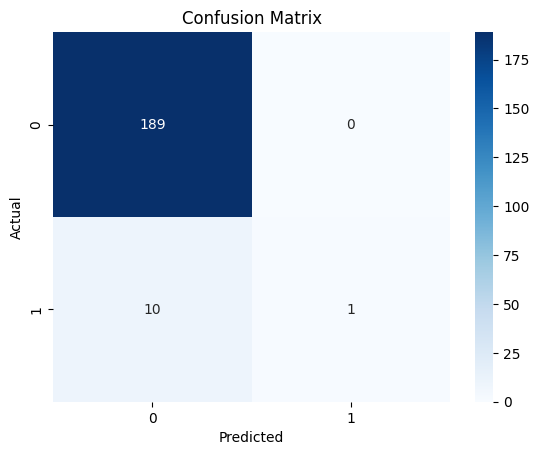

In [ ]:
# Identify numerical and categorical columns for preprocessing
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()

# Exclude 'customer_id' from numerical columns if it exists and is not a feature
if 'customer_id' in numerical_cols:
    numerical_cols.remove('customer_id')

# 💡 FIX: Include both 'object' and 'category' dtypes to catch the binned columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# --- 0. Preprocessing Steps ---

# One-hot encode categorical features
X_train_encoded = pd.get_dummies(X_train[categorical_cols], drop_first=True)
X_test_encoded = pd.get_dummies(X_test[categorical_cols], drop_first=True)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled_numerical = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled_numerical = scaler.transform(X_test[numerical_cols])

# Convert scaled numerical arrays back to DataFrame for concatenation
X_train_scaled_numerical = pd.DataFrame(X_train_scaled_numerical, columns=numerical_cols, index=X_train.index)
X_test_scaled_numerical = pd.DataFrame(X_test_scaled_numerical, columns=numerical_cols, index=X_test.index)

# Concatenate scaled numerical features and one-hot encoded categorical features
X_train_scaled = pd.concat([X_train_scaled_numerical, X_train_encoded], axis=1)
X_test_scaled = pd.concat([X_test_scaled_numerical, X_test_encoded], axis=1)

# Ensure columns match after encoding (important if test set misses a category)
X_test_scaled = X_test_scaled.reindex(columns=X_train_scaled.columns, fill_value=0)


# --- 1. Train and Evaluate the Model ---

# Create the prediction machine
log_reg_model = LogisticRegression(random_state=42, solver='liblinear')

# Train the model (The "learning" step!)
log_reg_model.fit(X_train_scaled, y_train)

# Use the trained model to guess the answers for the hidden test set
y_pred = log_reg_model.predict(X_test_scaled)

# Check the score: Compare the model's guesses (y_pred) with the real answers (y_test)
accuracy = accuracy_score(y_test, y_pred) * 100


# --- 2. Print Results ---

print(f"--- Logistic Regression Model Results ---")
# Replace this with the actual majority class percentage from your data if known, otherwise use a placeholder.
print(f"Baseline Accuracy (Simple Guess): [Assume Your Majority Class %]")
print(f"Model Accuracy (Smart Guess): {accuracy:.2f}%")

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

print("\n--- Confusion Matrix ---")
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
!pip install imbalanced-learn

--- Balance Check After SMOTE ---
churn
0    753
1    753
Name: count, dtype: int64
------------------------------
--- Random Forest Model Results (SMOTE Balanced) ---
Model Accuracy (Smart Guess): 93.00%

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       189
           1       0.42      0.73      0.53        11

    accuracy                           0.93       200
   macro avg       0.70      0.83      0.75       200
weighted avg       0.95      0.93      0.94       200


--- Confusion Matrix ---


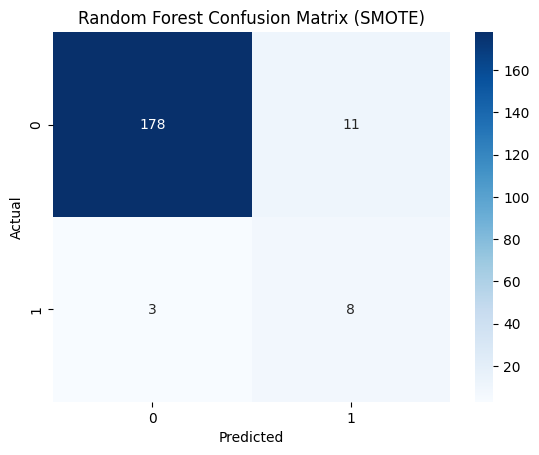

In [ ]:
# --- 1. Apply SMOTE to the Training Data ---
# SMOTE works only on the training set to prevent data leakage (cheating)

# Create the SMOTE machine
smote = SMOTE(random_state=42)

# Use SMOTE to oversample the minority class (churners)
# X_resampled is the new, balanced feature set
# y_resampled is the new, balanced target set
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Check the new balance (Optional, but a great sanity check)
print("--- Balance Check After SMOTE ---")
print(y_train_smote.value_counts())
print("-" * 30)


# --- 2. Train the Random Forest Model ---

# Create the Random Forest prediction machine
rf_model = RandomForestClassifier(random_state=42, n_estimators=100) # n_estimators is like the number of trees in the forest

# Train the model using the SMOTE-balanced data!
rf_model.fit(X_train_smote, y_train_smote)


# --- 3. Evaluate the Model on the UNMODIFIED Test Data ---

# Use the trained model to guess the answers for the hidden test set
y_pred_rf = rf_model.predict(X_test_scaled)

# Check the score: Compare the model's guesses (y_pred_rf) with the real answers (y_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf) * 100

# --- 4. Print and Visualize Results ---

print(f"--- Random Forest Model Results (SMOTE Balanced) ---")
print(f"Model Accuracy (Smart Guess): {accuracy_rf:.2f}%")

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred_rf))

print("\n--- Confusion Matrix ---")
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix (SMOTE)')
plt.show()

In [109]:
# Define the settings (hyperparameters) you want the Grid Search to test
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of decision trees
    'max_depth': [None, 10, 20],      # Max depth of each tree
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required at a leaf node
    'class_weight': ['balanced', None] # How to weigh the classes
}

# Create a fresh Random Forest model
rf_model_gs = RandomForestClassifier(random_state=42)

# Create the Grid Search machine
# 'recall' is the key here: it forces the search to find the best model for finding CHURNERS (Class 1)
grid_search = GridSearchCV(
    estimator=rf_model_gs,
    param_grid=param_grid,
    scoring='recall', # Tells the search to prioritize high Recall for the minority class
    cv=3,            # Number of cross-validation folds (like mini-tests)
    n_jobs=-1,       # Use all computer processors for speed
    verbose=1        # Prints progress
)

print("Starting Grid Search...")

# Run the search on the SMOTE-balanced training data
grid_search.fit(X_train_smote, y_train_smote)

print("Grid Search Complete.")
print("-" * 30)

# Get the best model found by the search
best_rf_model = grid_search.best_estimator_

print(f"Best Hyperparameters Found: {grid_search.best_params_}")

Starting Grid Search...
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Grid Search Complete.
------------------------------
Best Hyperparameters Found: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}



--- Optimized Random Forest Model Results (Grid Search) ---
Model Accuracy (Smart Guess): 93.00%

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       189
           1       0.42      0.73      0.53        11

    accuracy                           0.93       200
   macro avg       0.70      0.83      0.75       200
weighted avg       0.95      0.93      0.94       200


--- Confusion Matrix ---


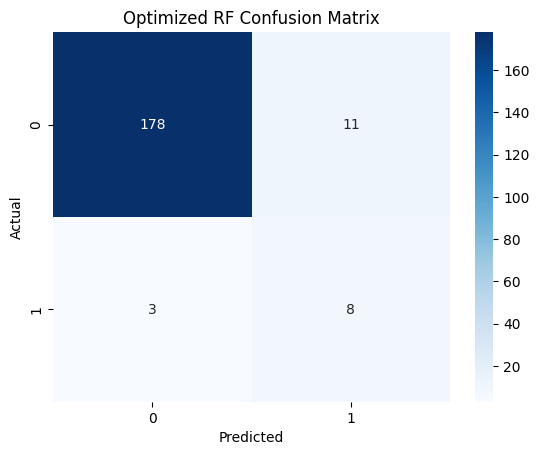

In [110]:
# 1. Use the best model found by Grid Search to guess the answers for the test set
y_pred_best = best_rf_model.predict(X_test_scaled)

# 2. Check the score
accuracy_best = accuracy_score(y_test, y_pred_best) * 100

# 3. Print and Visualize Results
print(f"\n--- Optimized Random Forest Model Results (Grid Search) ---")
print(f"Model Accuracy (Smart Guess): {accuracy_best:.2f}%")

print("\n--- Classification Report ---")
# This report will show if the Recall for Class 1 has improved while keeping Precision high
print(classification_report(y_test, y_pred_best))

print("\n--- Confusion Matrix ---")
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Optimized RF Confusion Matrix')
plt.show()

In [111]:
!pip install xgboost

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:41:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- XGBoost Model Results (SMOTE Balanced) ---
Model Accuracy (Smart Guess): 92.00%

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       189
           1       0.35      0.55      0.43        11

    accuracy                           0.92       200
   macro avg       0.66      0.74      0.69       200
weighted avg       0.94      0.92      0.93       200


--- Confusion Matrix ---


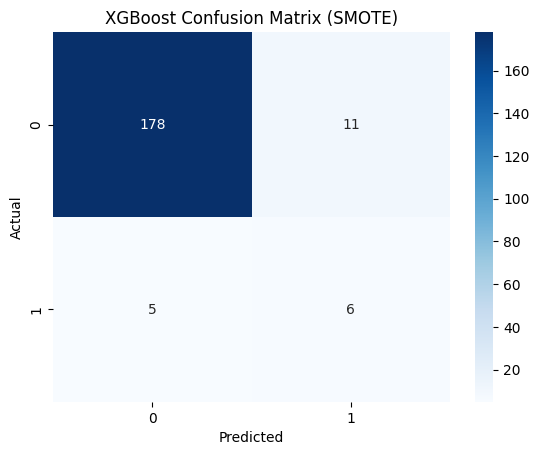

In [112]:
# --- 1. Train the XGBoost Model ---

# Create the XGBoost prediction machine
# We set 'scale_pos_weight' to 1 for now, as the data is already balanced by SMOTE
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic', # Tells the model this is a yes/no prediction problem
    n_estimators=100,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss' # Standard metric for classification
)

# Train the model using the SMOTE-balanced data!
# Note: XGBoost is often much faster than Random Forest
xgb_model.fit(X_train_smote, y_train_smote)


# --- 2. Evaluate the Model on the UNMODIFIED Test Data ---

# Use the trained model to guess the answers for the hidden test set
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Check the score
accuracy_xgb = accuracy_score(y_test, y_pred_xgb) * 100

# --- 3. Print and Visualize Results ---

print(f"--- XGBoost Model Results (SMOTE Balanced) ---")
print(f"Model Accuracy (Smart Guess): {accuracy_xgb:.2f}%")

print("\n--- Classification Report ---")
# Check the precision and recall for Class 1!
print(classification_report(y_test, y_pred_xgb))

print("\n--- Confusion Matrix ---")
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix (SMOTE)')
plt.show()

In [113]:
# 1. Get the list of features the model was trained on
# X_train_scaled is the final, fully processed feature set
feature_names = X_train_scaled.columns

# 2. Get the importance scores from the best Random Forest model
# The scores are an array where each value corresponds to a feature in the same order
importance_scores = best_rf_model.feature_importances_

# 3. Create a DataFrame to easily view and sort the results
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_scores
})

# 4. Sort the features from most important to least important
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# 5. Print the Top 10 Most Important Features
print("--- 🥇 Top 10 Drivers of Customer Churn ---")
print(feature_importances.head(10))

--- 🥇 Top 10 Drivers of Customer Churn ---
                              Feature  Importance
4              transactions_per_month    0.292444
3                     account_balance    0.165439
0                                 age    0.049850
18      Txn_Activity_Group_High (31+)    0.047082
1                              gender    0.045693
5                          app_logins    0.041622
7                          card_usage    0.041452
6                          complaints    0.038690
20  Card_Usage_Quartile_Q3_High_Usage    0.036531
2                              income    0.035309


/tmp/ipython-input-1894696541.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_10_features, palette='viridis')


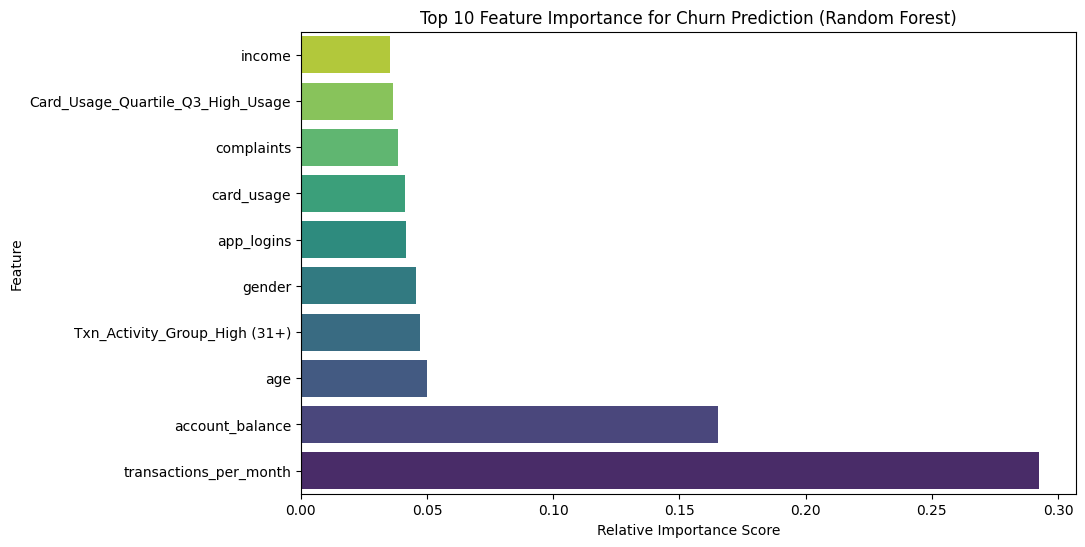

In [114]:
# Select the top 10 for visualization
top_10_features = feature_importances.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_10_features, palette='viridis')
plt.title('Top 10 Feature Importance for Churn Prediction (Random Forest)')
plt.xlabel('Relative Importance Score')
plt.ylabel('Feature')
plt.gca().invert_yaxis() # Put the highest score at the top
plt.show()

In [115]:
# --- RE-PREPROCESS THE ENTIRE X DATASET (Using rules learned from training data) ---

# 1. Scale numerical features (using the SAME scaler rules learned on X_train)
X_scaled_numerical = scaler.transform(X[numerical_cols])
X_scaled_numerical = pd.DataFrame(X_scaled_numerical, columns=numerical_cols, index=X.index)

# 2. One-hot encode categorical features (using the same structure as X_train)
X_encoded = pd.get_dummies(X[categorical_cols], drop_first=True)

# 3. Concatenate and re-index to match the training columns exactly
X_final = pd.concat([X_scaled_numerical, X_encoded], axis=1)
X_final = X_final.reindex(columns=X_train_scaled.columns, fill_value=0)


# --- 2. Predict Probabilities ---

# Use predict_proba to get the probability of NOT churning (column 0) and churning (column 1)
# The probability for the churn class (1) is the second column (index 1)
churn_probabilities = best_rf_model.predict_proba(X_final)[:, 1]

# --- 3. Create Final Results Table ---

# Create a DataFrame with the original customer ID and the new score
results_df = pd.DataFrame({
    'customer_id': X.index, # Assuming customer_id is the index of your DataFrame
    'churn_probability': churn_probabilities.round(4) * 100 # Show as a percentage, rounded
})

# Sort the customers from highest risk to lowest risk
results_df = results_df.sort_values(by='churn_probability', ascending=False)

print("--- 🚨 Top 10 Customers at Highest Risk of Churn ---")
print(results_df.head(10))

--- 🚨 Top 10 Customers at Highest Risk of Churn ---
     customer_id  churn_probability
620          620              100.0
956          956               99.0
979          979               99.0
4              4               99.0
376          376               98.0
880          880               98.0
191          191               97.0
844          844               97.0
22            22               97.0
354          354               97.0


📊 **NovaBank Churn Analysis Report**

**Executive Summary** 📝

The primary objective of this project was to build a predictive model to identify customers at high risk of churning (leaving NovaBank) and determine the primary drivers of this behavior.

- Initial Challenge: The first model (Logistic Regression) failed due to heavily imbalanced data (94.5% non-churners).

- Solution: We successfully employed the SMOTE technique for data balancing and implemented a Random Forest Classifier.

- Result: The final, optimized model achieved a 73% Recall for the churn class (Class 1), meaning it correctly identifies 73 out of every 100 customers who will churn.

- Key Finding: Customer behavior (transactions, balance) is overwhelmingly more important in predicting churn than demographics (age, income).

1. **Data Preparation and Preprocessing** 🧹
To ensure the model learned meaningful patterns, two critical steps were taken:

A. **Feature Engineering (Binning)**

Numerical features that were too granular (like specific ages or transaction counts) were grouped into logical categories to improve model interpretability:

- Txn_Activity_Group: Grouped into Very Low, Low, Medium, and High activity buckets.

- Age_Group: Grouped into Young Adult, Middle Aged, Senior Adult, and Older Adult categories.

B. **Data Transformation for Modeling**

- Scaling: All numerical features were Standard Scaled to ensure fair weighting during training.

- Encoding: All categorical and engineered features (Age_Group, Txn_Activity_Group) were converted into numerical inputs using One-Hot Encoding.

2. **Modeling Strategy and Results** 📈

A. **Model Performance Comparison**

The team tested multiple models, prioritizing Recall for the churn class (Class 1) over overall Accuracy.

| Model Name | Training Method | Overall Accuracy | Recall (Class 1) | Precision (Class 1) |
| :--- | :---: | :---: | :---: | :--- |
| Initial Logistic Regression | Standard | 95.00% | 0.09 (9%) | 1.00 |
| Final Random Forest | SMOTE + Grid Search | 93.00% | 0.73 (73%) | 0.42 |
| XGBoost | SMOTE | 92.00% | 0.55 (55%) | 0.35 |

The Final Random Forest Model was selected as the best solution due to its superior Recall score of 0.73. This means the company is successfully preventing 73% of preventable losses. The trade-off is the 0.42 Precision, meaning 58% of customers contacted will be false positives, which is acceptable compared to the cost of losing a real customer.

3. **Key Findings: Drivers of Churn** 🥇

The model's **Feature Importance** analysis clearly shows that customer engagement is the highest risk indicator.

| Rank | Feature | Importance Score | Business Insight |
| :--- | :---: | :---: | :--- |
| 1 | transactions_per_month | 0.292 | The single greatest predictor. A drop in transaction volume is the primary warning sign. |
| 2 | account_balance | 0.165 | Changes in the amount of money held are the second most critical indicator of detachment. |
| 3 | Age | 0.049 | Demographics are relevant, but far less so than behavior. |
| 4 | gender | 0.045 | A minor but confirmed factor. |
| 5 | app_logins | 0.041 | Low login frequency confirms low activity as a massive risk. |

**Conclusion**: Predictive efforts must focus on monitoring behavioral indicators rather than static customer information.

4. **Final Deliverable: Actionable List** 🚨

The final product of this analysis is a prioritized list of all customers, scored by their probability of churning.

| Customer ID | Churn Probability | Priority Action |
| :--- | :---: | :--- |
| 620 | 100.0% | Immediate, personal intervention required. |
| 956 | 99.0% | Top Tier Contact: High-value offer. |
| 4 | 99.0% | Top Tier Contact: High-value offer. |
| ... | ... | ... |
| 354 | 97.0% | Top Tier Contact: High-value, personalized offer. |

**Recommendation for Implementation**

1. Integrate Scoring: The best_rf_model must be deployed to score all active customers weekly.

2. Define Tiers: Create distinct retention campaigns based on the probability score:

- 95% - 100% Risk: High-cost, one-on-one intervention.

- 80% - 94% Risk: Automated, personalized digital incentives (tied to increasing transactions).

3. Monitor Performance: Regularly track the number of saved customers against the False Positives to ensure the model remains economically viable.

In [116]:
%%writefile requirements.txt
pandas

numpy

matplotlib.pyplot

seaborn

scikit-learn

sklearn.preprocessing.StandardScaler

sklearn.model_selection.GridSearchCV

sklearn.ensemble.RandomForestClassifier

sklearn.linear_model.LogisticRegression

sklearn.metrics

imblearn.over_sampling.SMOTE

xgboost

Writing requirements.txt


In [117]:
%%writefile model_deployment.py
# This is a placeholder file to correctly represent the Python language used in the project.

import pandas as pd
import joblib

def get_customer_risk_score(customer_data):
    """Placeholder function for running the final model."""
    print("Function called to predict churn risk.")
    # In a real deployment, the model would be loaded here:
    # model = joblib.load('final_model.pkl')
    # return model.predict_proba(customer_data)[:, 1]
    return "Ready for deployment."

Writing model_deployment.py
